In [143]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from utils.utils import *
import pandas as pd
import cv2

In [144]:
def get_patches_loss(losses, index):
    patch_losses = losses[num_patches* index: num_patches*(index+1)]
    patch_losses = patch_losses.reshape(30,30)
    patch_losses = patch_losses / patch_losses.sum()
    return patch_losses

def plot_heat_map(losses, name):
    patch_losses = get_patches_loss(losses, image_index)
    # plt.matshow(patch_losses)
    # plt.axis('off')
    # plt.colorbar()
    # plt.savefig(f'./figure/{index}_all_losses.png', bbox_inches='tight', pad_inches=0)
    
    # fig, ax = plt.subplots()
    # cax = ax.matshow(patch_losses)
    # cbar = fig.colorbar(cax)
    # cbar.mappable.set_clim(vmin=0, vmax=0.025)
    
    fig, ax = plt.subplots()
    cax = ax.matshow(patch_losses, vmin=0, vmax=model_index_map[model_dataset][2])
    # cax = ax.matshow(patch_losses)
    plt.colorbar(cax).remove()
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(f'./figures/{name}.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    
def plot_heat_map_with_bar(losses):
    patch_losses = get_patches_loss(losses, image_index)
    plt.matshow(patch_losses)
    plt.axis('off')
    plt.colorbar()
    plt.show()
    
    
def plot_four_figure():
    true_loss = get_patches_loss(true_losses, image_index)
    vit_loss = get_patches_loss(vit_losses, image_index)
    at_loss = get_patches_loss(at_losses, image_index)
    ase_loss = get_patches_loss(ase_losses, image_index)
    
    vmin, vmax = 0, model_index_map[model_dataset][2]
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0, 0].matshow(true_loss, vmin=vmin, vmax=vmax)
    axs[0, 0].set_title('Ground-truth Distribution')

    axs[0, 1].matshow(vit_loss, vmin=vmin, vmax=vmax)
    axs[0, 1].set_title('Our ViTAL')

    axs[1, 0].matshow(at_loss, vmin=vmin, vmax=vmax)
    axs[1, 0].set_title('ATS')

    axs[1, 1].matshow(ase_loss, vmin=vmin, vmax=vmax)
    axs[1, 1].set_title('ASE')
    
    for ax in axs.flat:
        plt.colorbar(ax.images[0], ax=ax).remove()
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

model_index_map = {"PSPNet_VOC": [10000, 827, 0.025], "PSPNet_CITY": [10000, 49, 0.05], "PSPNet_COCO": [60000, 856, 0.0016], 
                   "PSPNet_ADE20K": [5000, 1652, 0.0025], "UNet_VOC": [25000, 476, 0.007], "UNet_CITY": [10000, 61, 0.008],
                  "UNet_COCO": [15000, 201, 0.004], "UNet_ADE20K": [15000, 819, 0.0035]}

## Display image

In [135]:
def get_image_name_by_index(index, dataset):
    if dataset == "VOC":
        file_list = "/data/active_testing/active_testing_seg/datasets/PascalVOC/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"
        image_list = [name.rstrip() for name in tuple(open(file_list, "r"))]
        return image_list[index] + ".jpg"
    elif dataset == "COCO":
        file_list = os.path.join("/data/active_testing/active_testing_seg/datasets/coco10k", 'imageLists', 'test.txt')
        image_list = [name.rstrip() for name in tuple(open(file_list, "r"))]
        return image_list[index] + ".jpg"

def display_image(index, image_name, save_name, dataset):
    from PIL import Image
    import matplotlib.pyplot as plt

    # Open the image
    if dataset == "VOC":
        image_path = "/data/active_testing/active_testing_seg/datasets/PascalVOC/VOCdevkit/VOC2012/JPEGImages/" + image_name # Replace with the actual image path
    elif dataset == "COCO":
        image_path = "/data/active_testing/active_testing_seg/datasets/coco10k/images/" + image_name
    
    # image = Image.open(image_path)
    image = np.asarray(Image.open(image_path), dtype=np.float32)
    
    crop_size = 480
    h, w = image.shape[:2]
    # Scale the smaller side to crop size
    if h < w:
        h, w = (crop_size, int(crop_size * w / h))
    else:
        h, w = (int(crop_size * h / w), crop_size)

    image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)

    # Center Crop
    h, w = image.shape[:2]
    start_h = (h - crop_size )// 2
    start_w = (w - crop_size )// 2
    end_h = start_h + crop_size
    end_w = start_w + crop_size
    image = image[start_h:end_h, start_w:end_w]

    # Display the image using matplotlib
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')  # Turn off axes
    plt.savefig(f'./figures/{save_name}.png', bbox_inches='tight', pad_inches=0)
    plt.show()

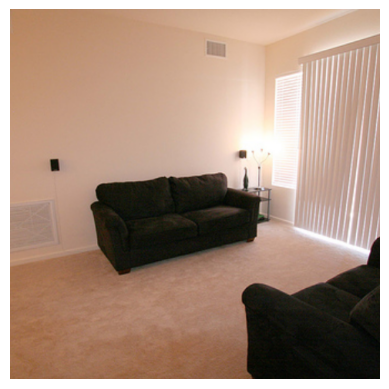

In [138]:
index = 476
display_image(index, get_image_name_by_index(index, "VOC"), "UNet_VOC_image", "VOC")

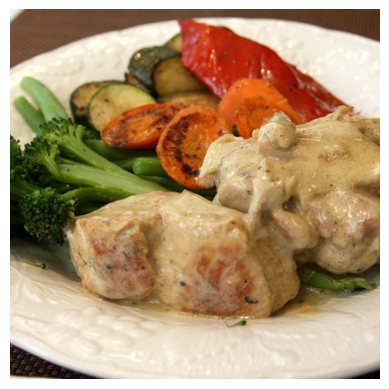

In [139]:
index = 201
# get_image_name_by_index(index, "COCO")
display_image(index, get_image_name_by_index(index, "COCO"), "UNet_COCO_image", "COCO")

## Select figure

In [145]:
model_dataset = "PSPNet_VOC"
train_step = model_index_map[model_dataset][0]
num_patches = 900
if model_dataset[-1] == "0":
    model_origin_folder = model_dataset[:-3]
else:
    model_origin_folder = model_dataset
base_path = f"./pro_data/{model_origin_folder}/val/"
true_losses = np_read(base_path + "region_16_16_true_losses.npy")
vit_losses = np.array(read_one_results(f"../ViT-pytorch/output/ViT_{model_dataset}_region_losses_{train_step}.json")['losses'])
ase_store_path = f"./ase_results/{model_origin_folder}/"
at_losses = np_read(ase_store_path + f"AT_{model_origin_folder}_region_16_Q.npy")
ase_losses = np_read(ase_store_path + f"ASE_{model_origin_folder}_region_16_Q.npy")

In [146]:
image_nums = true_losses.shape[0] // num_patches
best_index = 0
best_value = -1000
for index in range(image_nums):
    diff_true_vit = np.abs(get_patches_loss(vit_losses, index) - get_patches_loss(true_losses, index)).mean()
    diff_true_at = np.abs(get_patches_loss(at_losses, index) - get_patches_loss(true_losses, index)).mean()
    diff_true_ase = np.abs(get_patches_loss(ase_losses, index) - get_patches_loss(true_losses, index)).mean()
    # curr_diff = diff_true_at + diff_true_ase - 2*diff_true_vit
    curr_diff = diff_true_ase - diff_true_vit
    if curr_diff > best_value:
        best_value = curr_diff
        best_index = index
print(best_index, best_value)

476 0.000758761687776637


In [147]:
image_nums = true_losses.shape[0] // num_patches
best_index = 0
best_value = 1000
for index in range(image_nums):
    diff_true_vit = np.abs(get_patches_loss(vit_losses, index) - get_patches_loss(true_losses, index)).mean()
    if diff_true_vit < best_value:
        best_value = diff_true_vit
        best_index = index
print(best_index, best_value)

689 0.0001290946317134406


In [ ]:
image_index = best_index
plot_heat_map_with_bar(true_losses)

In [ ]:
image_index = model_index_map[model_dataset][1]
plot_four_figure()

## PSPNet_VOC

PSPNet_VOC


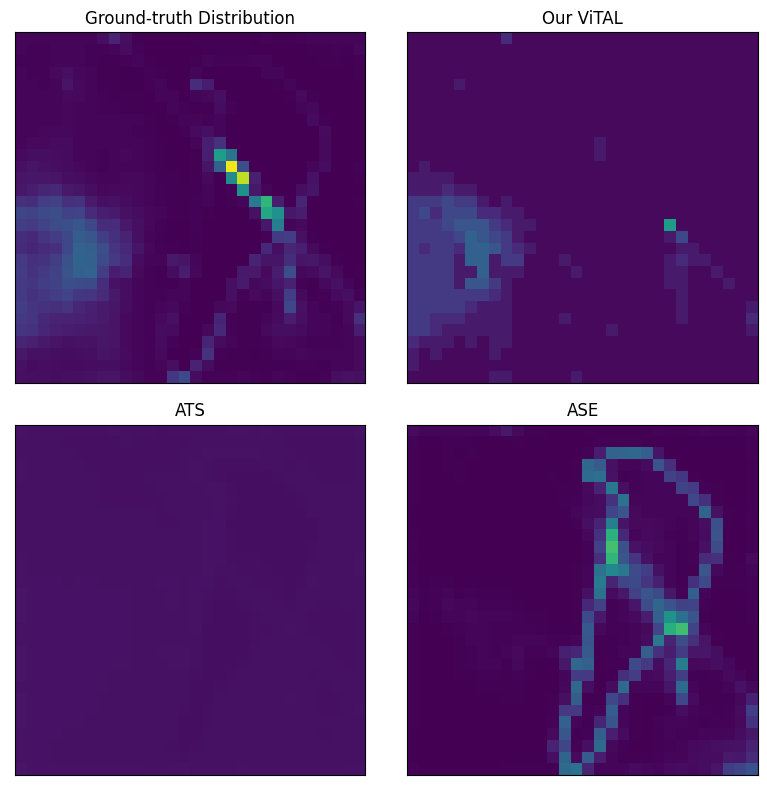

In [49]:
model_dataset = "PSPNet_VOC"
train_step = model_index_map[model_dataset][0]
num_patches = 900
if model_dataset[-1] == "0":
    model_origin_folder = model_dataset[:-3]
else:
    model_origin_folder = model_dataset
base_path = f"./pro_data/{model_origin_folder}/val/"
true_losses = np_read(base_path + "region_16_16_true_losses.npy")
vit_losses = np.array(read_one_results(f"../ViT-pytorch/output/ViT_{model_dataset}_region_losses_{train_step}.json")['losses'])
ase_store_path = f"./ase_results/{model_origin_folder}/"
at_losses = np_read(ase_store_path + f"AT_{model_origin_folder}_region_16_Q.npy")
ase_losses = np_read(ase_store_path + f"ASE_{model_origin_folder}_region_16_Q.npy")

print("PSPNet_VOC")
image_index = model_index_map[model_dataset][1]
plot_four_figure()

PSPNet_CITY


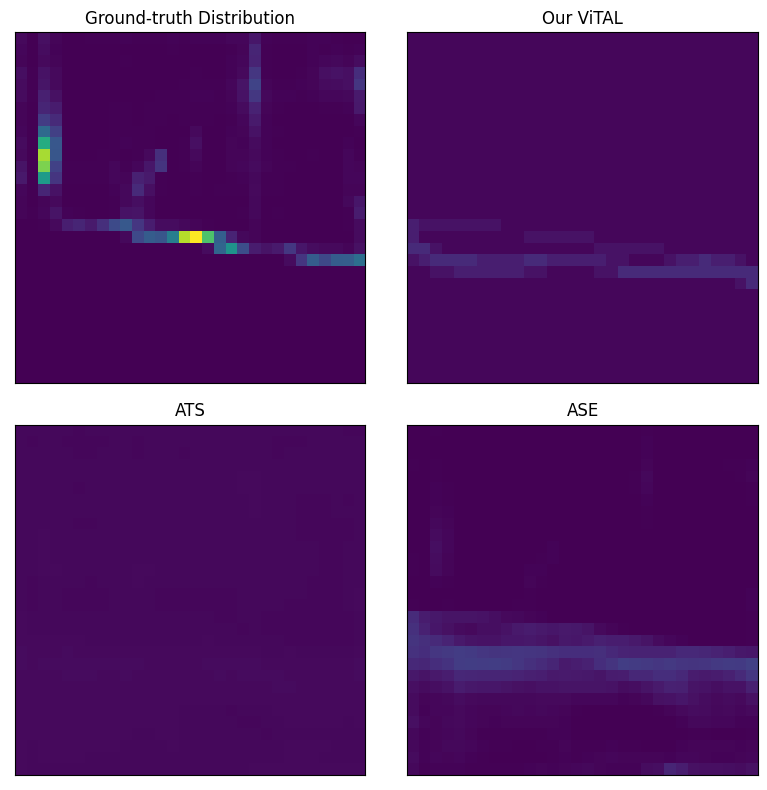

In [50]:
model_dataset = "PSPNet_CITY"
train_step = model_index_map[model_dataset][0]
num_patches = 900
if model_dataset[-1] == "0":
    model_origin_folder = model_dataset[:-3]
else:
    model_origin_folder = model_dataset
base_path = f"./pro_data/{model_origin_folder}/val/"
true_losses = np_read(base_path + "region_16_16_true_losses.npy")
vit_losses = np.array(read_one_results(f"../ViT-pytorch/output/ViT_{model_dataset}_region_losses_{train_step}.json")['losses'])
ase_store_path = f"./ase_results/{model_origin_folder}/"
at_losses = np_read(ase_store_path + f"AT_{model_origin_folder}_region_16_Q.npy")
ase_losses = np_read(ase_store_path + f"ASE_{model_origin_folder}_region_16_Q.npy")
print("PSPNet_CITY")
image_index = model_index_map[model_dataset][1]
plot_four_figure()

PSPNet_COCO


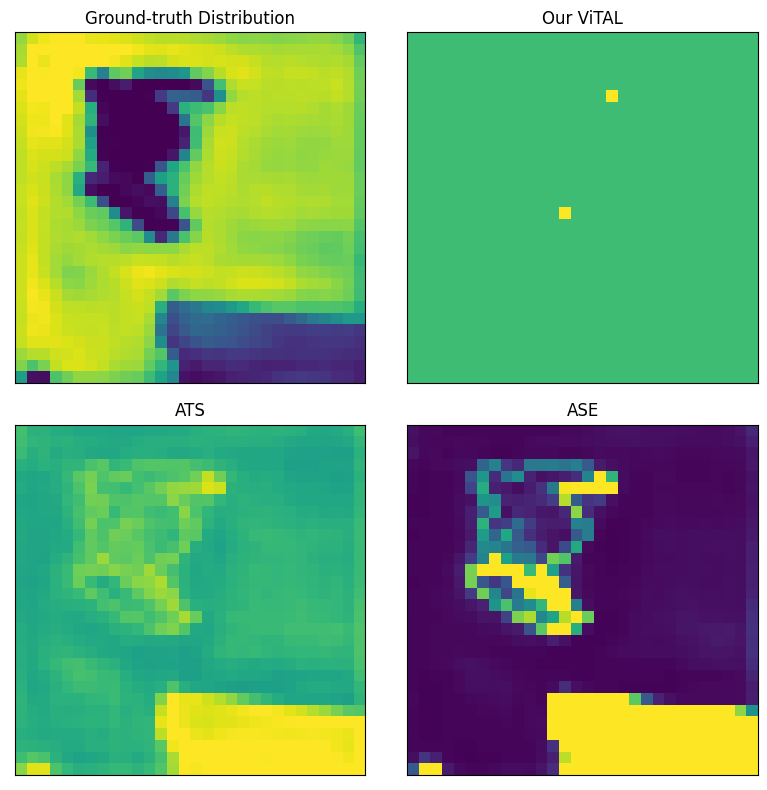

In [51]:
model_dataset = "PSPNet_COCO"
train_step = model_index_map[model_dataset][0]
num_patches = 900
if model_dataset[-1] == "0":
    model_origin_folder = model_dataset[:-3]
else:
    model_origin_folder = model_dataset
base_path = f"./pro_data/{model_origin_folder}/val/"
true_losses = np_read(base_path + "region_16_16_true_losses.npy")
vit_losses = np.array(read_one_results(f"../ViT-pytorch/output/ViT_{model_dataset}_region_losses_{train_step}.json")['losses'])
ase_store_path = f"./ase_results/{model_origin_folder}/"
at_losses = np_read(ase_store_path + f"AT_{model_origin_folder}_region_16_Q.npy")
ase_losses = np_read(ase_store_path + f"ASE_{model_origin_folder}_region_16_Q.npy")
print(model_dataset)
image_index = model_index_map[model_dataset][1]
plot_four_figure()

PSPNet_ADE20K


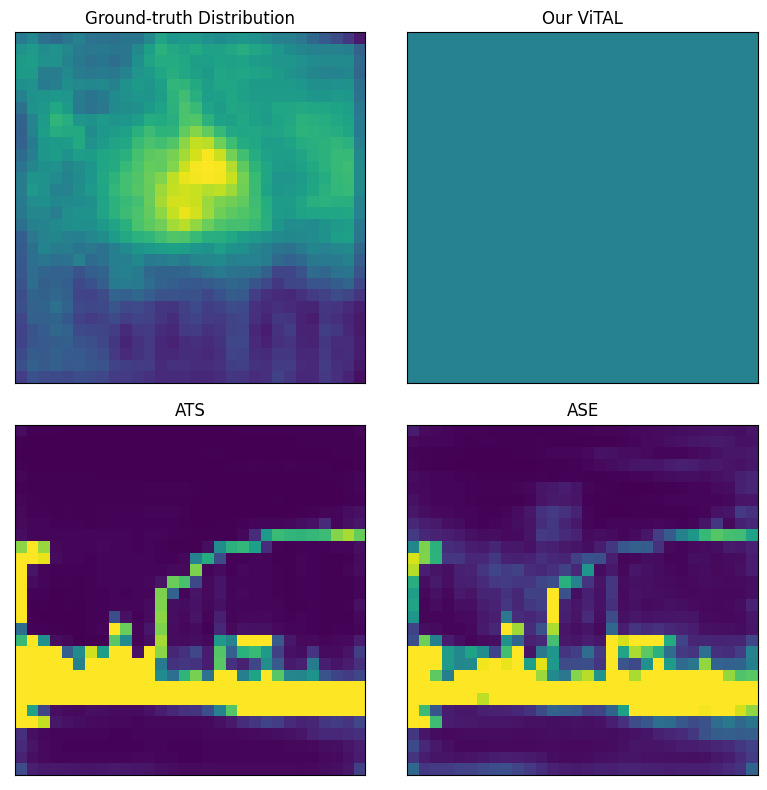

In [58]:
model_dataset = "PSPNet_ADE20K"
train_step = model_index_map[model_dataset][0]
num_patches = 900
if model_dataset[-1] == "0":
    model_origin_folder = model_dataset[:-3]
else:
    model_origin_folder = model_dataset
base_path = f"./pro_data/{model_origin_folder}/val/"
true_losses = np_read(base_path + "region_16_16_true_losses.npy")
vit_losses = np.array(read_one_results(f"../ViT-pytorch/output/ViT_{model_dataset}_region_losses_{train_step}.json")['losses'])
ase_store_path = f"./ase_results/{model_origin_folder}/"
at_losses = np_read(ase_store_path + f"AT_{model_origin_folder}_region_16_Q.npy")
ase_losses = np_read(ase_store_path + f"ASE_{model_origin_folder}_region_16_Q.npy")
print(model_dataset)
image_index = model_index_map[model_dataset][1]
plot_four_figure()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


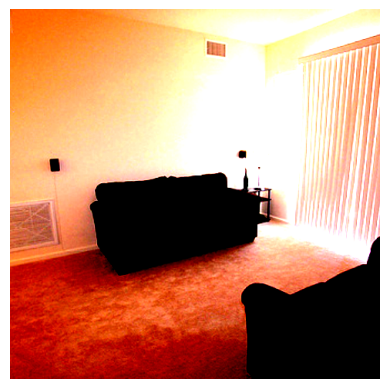

In [115]:
image_dir = base_path + "image/"
file_name = str(image_index//8) + ".npy"
one_image = np_read(image_dir + file_name)
image_index = image_index % 8
image = one_image[image_index]

image_to_show = np.transpose(image, (1, 2, 0))

# Display the image using plt.imshow
plt.imshow(image_to_show)
plt.axis('off')  # Remove axis ticks and labels

# Show the plot
plt.show()

## UNet_VOC

UNet_VOC


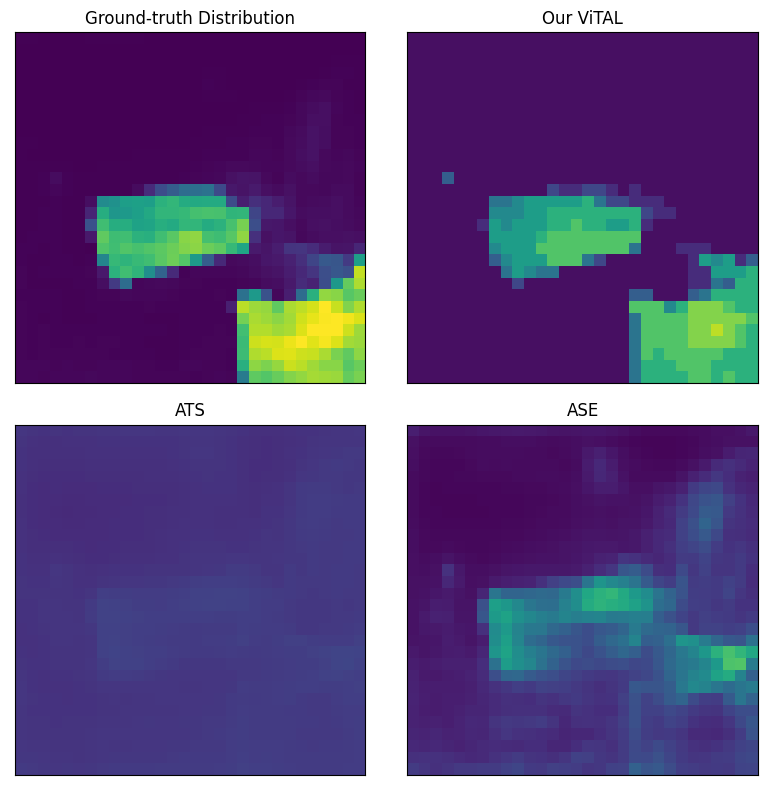

In [113]:
model_dataset = "UNet_VOC"
train_step = model_index_map[model_dataset][0]
num_patches = 900
if model_dataset[-1] == "0":
    model_origin_folder = model_dataset[:-3]
else:
    model_origin_folder = model_dataset
base_path = f"./pro_data/{model_origin_folder}/val/"
true_losses = np_read(base_path + "region_16_16_true_losses.npy")
vit_losses = np.array(read_one_results(f"../ViT-pytorch/output/ViT_{model_dataset}_region_losses_{train_step}.json")['losses'])
ase_store_path = f"./ase_results/{model_origin_folder}/"
at_losses = np_read(ase_store_path + f"AT_{model_origin_folder}_region_16_Q.npy")
ase_losses = np_read(ase_store_path + f"ASE_{model_origin_folder}_region_16_Q.npy")

print(model_dataset)
image_index = model_index_map[model_dataset][1]
plot_four_figure()

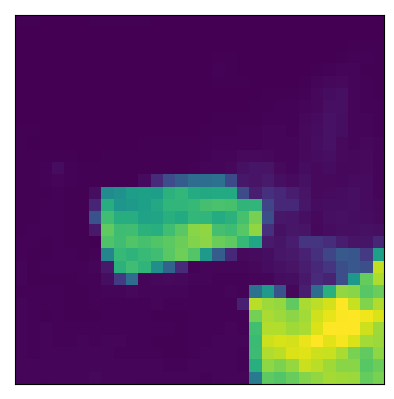

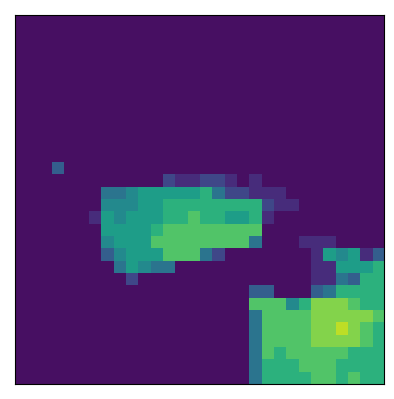

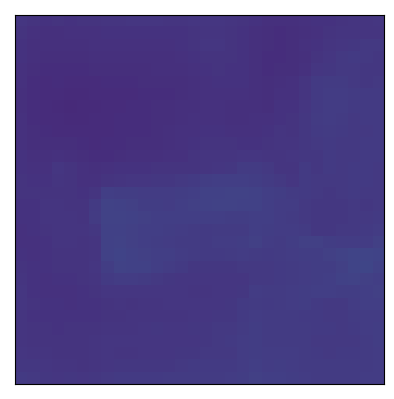

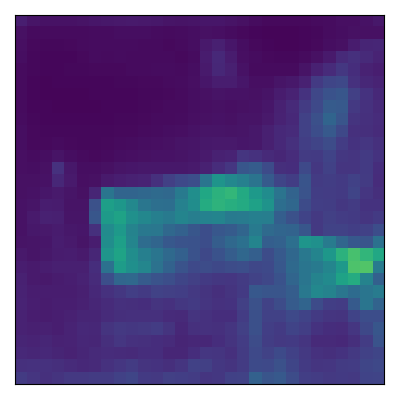

In [120]:
image_index = model_index_map[model_dataset][1]
plot_heat_map(true_losses, "UNet_VOC_true_loss")
plot_heat_map(vit_losses, "UNet_VOC_our")
plot_heat_map(at_losses, "UNet_VOC_ATS")
plot_heat_map(ase_losses, "UNet_VOC_ASE")

## UNet_CITY

UNet_CITY


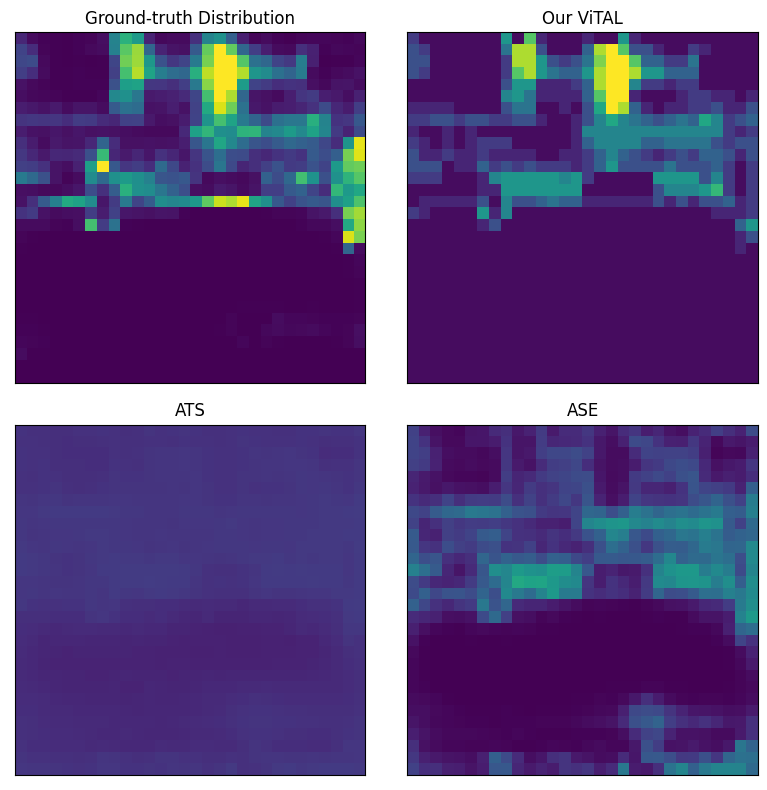

In [75]:
model_dataset = "UNet_CITY"
train_step = model_index_map[model_dataset][0]
num_patches = 900
if model_dataset[-1] == "0":
    model_origin_folder = model_dataset[:-3]
else:
    model_origin_folder = model_dataset
base_path = f"./pro_data/{model_origin_folder}/val/"
true_losses = np_read(base_path + "region_16_16_true_losses.npy")
vit_losses = np.array(read_one_results(f"../ViT-pytorch/output/ViT_{model_dataset}_region_losses_{train_step}.json")['losses'])
ase_store_path = f"./ase_results/{model_origin_folder}/"
at_losses = np_read(ase_store_path + f"AT_{model_origin_folder}_region_16_Q.npy")
ase_losses = np_read(ase_store_path + f"ASE_{model_origin_folder}_region_16_Q.npy")
print(model_dataset)
image_index = model_index_map[model_dataset][1]
plot_four_figure()

## UNet_COCO

UNet_COCO


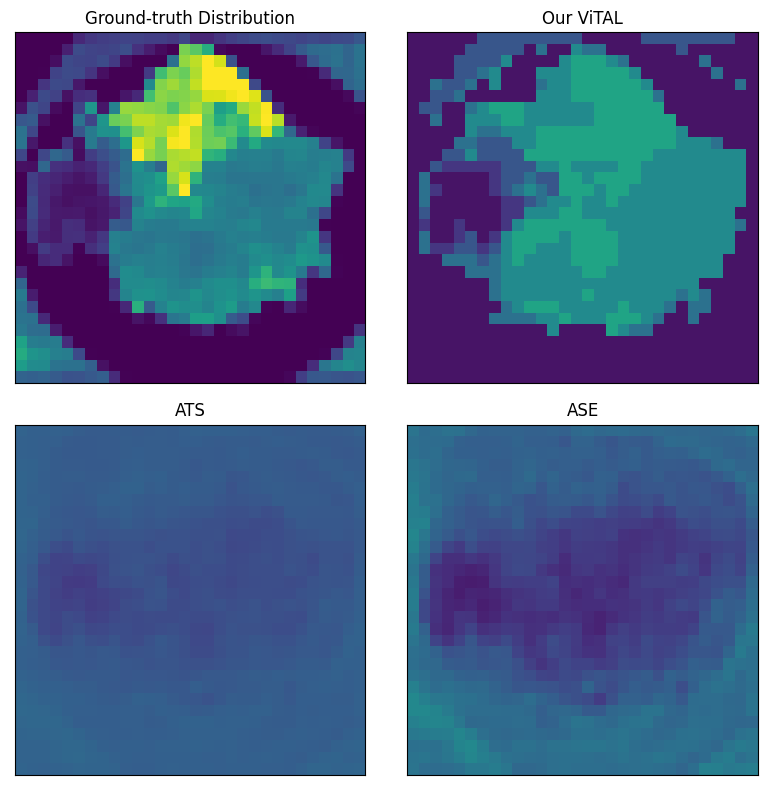

In [141]:
model_dataset = "UNet_COCO"
train_step = model_index_map[model_dataset][0]
num_patches = 900
if model_dataset[-1] == "0":
    model_origin_folder = model_dataset[:-3]
else:
    model_origin_folder = model_dataset
base_path = f"./pro_data/{model_origin_folder}/val/"
true_losses = np_read(base_path + "region_16_16_true_losses.npy")
vit_losses = np.array(read_one_results(f"../ViT-pytorch/output/ViT_{model_dataset}_region_losses_{train_step}.json")['losses'])
ase_store_path = f"./ase_results/{model_origin_folder}/"
at_losses = np_read(ase_store_path + f"AT_{model_origin_folder}_region_16_Q.npy")
ase_losses = np_read(ase_store_path + f"ASE_{model_origin_folder}_region_16_Q.npy")
print(model_dataset)
image_index = model_index_map[model_dataset][1]
plot_four_figure()

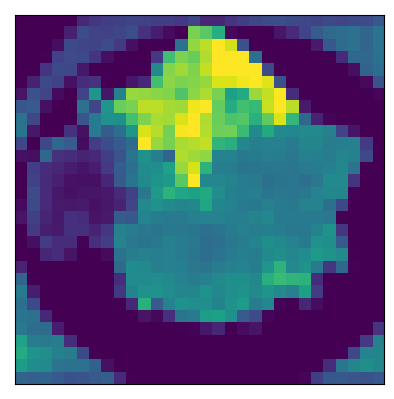

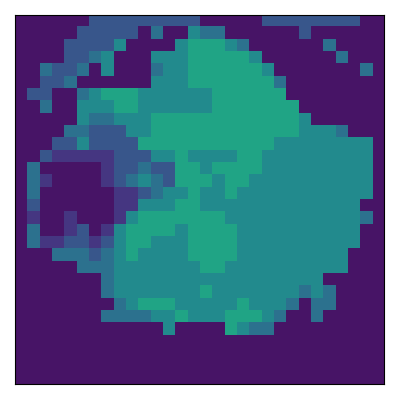

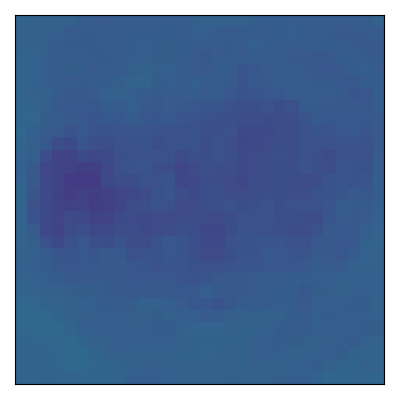

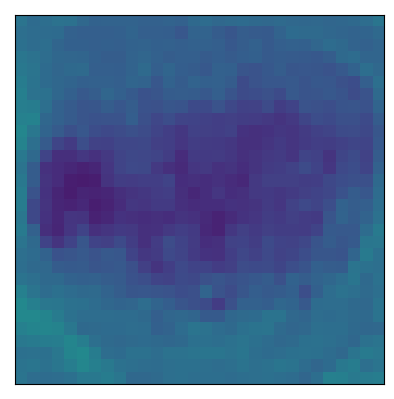

In [142]:
image_index = model_index_map[model_dataset][1]
plot_heat_map(true_losses, "UNet_COCO_true_loss")
plot_heat_map(vit_losses, "UNet_COCO_our")
plot_heat_map(at_losses, "UNet_COCO_ATS")
plot_heat_map(ase_losses, "UNet_COCO_ASE")

UNet_ADE20K


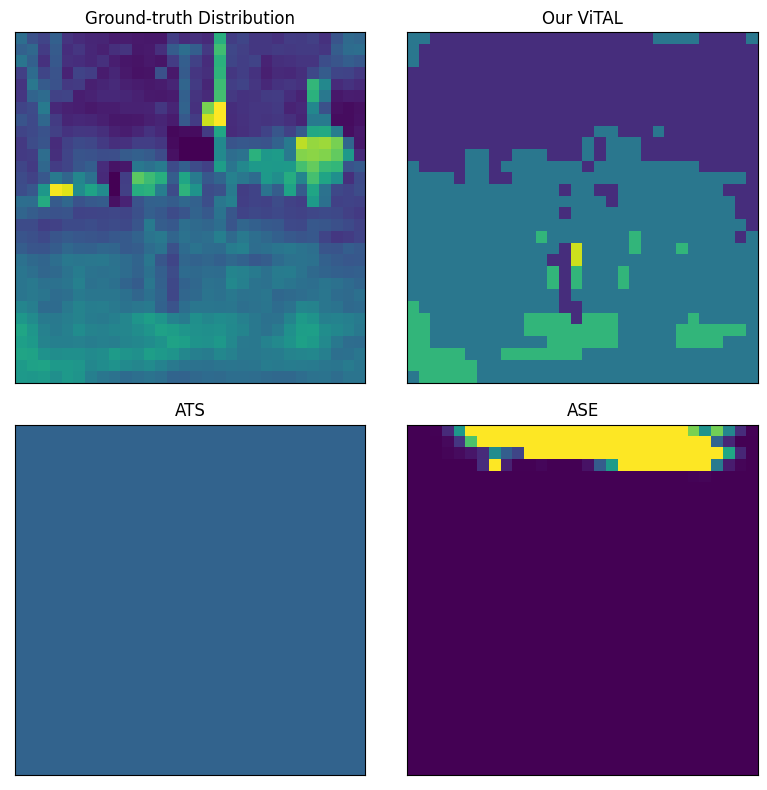

In [93]:
model_dataset = "UNet_ADE20K"
train_step = model_index_map[model_dataset][0]
num_patches = 900
if model_dataset[-1] == "0":
    model_origin_folder = model_dataset[:-3]
else:
    model_origin_folder = model_dataset
base_path = f"./pro_data/{model_origin_folder}/val/"
true_losses = np_read(base_path + "region_16_16_true_losses.npy")
vit_losses = np.array(read_one_results(f"../ViT-pytorch/output/ViT_{model_dataset}_region_losses_{train_step}.json")['losses'])
ase_store_path = f"./ase_results/{model_origin_folder}/"
at_losses = np_read(ase_store_path + f"AT_{model_origin_folder}_region_16_Q.npy")
ase_losses = np_read(ase_store_path + f"ASE_{model_origin_folder}_region_16_Q.npy")
print(model_dataset)
image_index = model_index_map[model_dataset][1]
plot_four_figure()

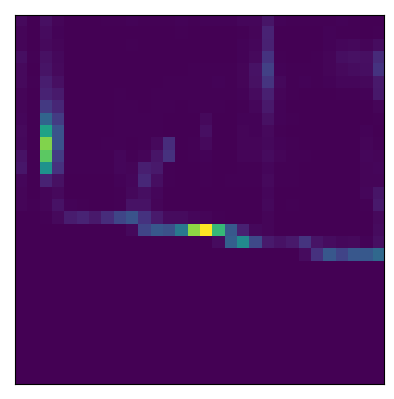

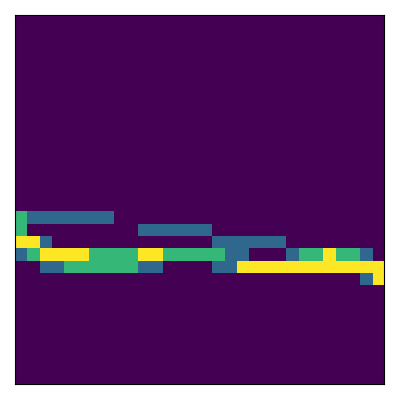

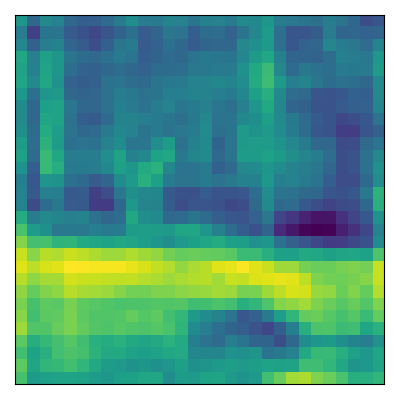

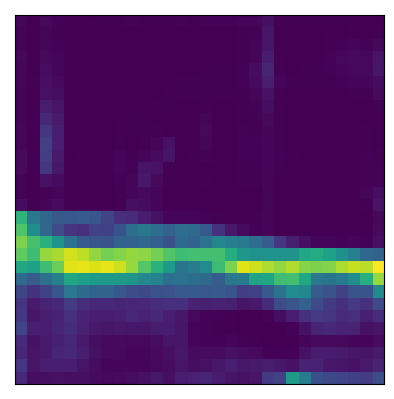

In [32]:
image_index = model_index_map[model_dataset][1]
plot_heat_map(true_losses)
plot_heat_map(vit_losses)
plot_heat_map(at_losses)
plot_heat_map(ase_losses)